# NLP2 Project 2: Cross-Lingual Transfer Learning
Authors: Berend Jansen (11051949) & Tom Lotze (11161159)

The structure of the notebook can be seen in the table of contents, and is as follows: 
- We train an MLP to learn the translation 
- Using this MLP we translate all test data once (for efficiency)
- We train a custom prediction head on top of BERT
- We evaluate the general performance of our model and the BERTje model
- We perform 2 experiments: Sentence length & POS-tags
- We do an ablation study, using google translate data

# Setup

In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelWithLMHead, BertForMaskedLM, BertTokenizer
from transformers import PretrainedConfig, BertConfig, BertModel
from transformers.modeling_bert import BertOnlyMLMHead
import torch.nn as nn
import torch
import copy
import os
import pickle as pkl
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from collections import Counter

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/Drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Drive/


NB: Please make sure the data directory can be accessed

In [ ]:
# correct directory
os.chdir('/content/Drive/My Drive/Colab Notebooks/NLP2/Project_2/')
os.getcwd()

'/content/Drive/My Drive/Colab Notebooks/NLP2/Project_2'

In [ ]:
# import BERTje and BERT models, tokenizers and embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERTje = BertForMaskedLM.from_pretrained("wietsedv/bert-base-dutch-cased").to(device)
BERT = BertForMaskedLM.from_pretrained('bert-base-cased').to(device)

bertje_tokenizer = AutoTokenizer.from_pretrained('wietsedv/bert-base-dutch-cased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

bertje_embeds = BERTje.get_input_embeddings()
bert_embeds = BERT.get_input_embeddings()


# MLP architecture to train embedding transformation



## Model

In [ ]:
# define simple MLP
class MLP(nn.Module):
    """Simple Pytorch Multi-layer perceptron class"""
    def __init__(self, n_inputs, n_hidden, n_classes, neg_slope):
        super(MLP, self).__init__()
        layer_list = []
        if n_hidden:
            for nr_nodes in n_hidden:
                layer_list.append(nn.Linear(n_inputs, nr_nodes))
                layer_list.append(nn.LeakyReLU(neg_slope))
                n_inputs = nr_nodes
        layer_list += [nn.Linear(n_inputs, n_classes)]
        self.layers = nn.ModuleList(layer_list)
        print(self.layers)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        out = x
        return out


## Data
- We create a training dataset for our MLP model, which learns a mapping from Dutch (BERTje) embeddings to English (BERT)Embeddings. 
- We extract the 40k most common words from the training set and obtain the tokenized tokens for those words. 
- To find the corresponding English words, we translated the 40k most common words using Google translate (word per word translation). To improve data quality, we filter out instances which include hashtags (#) from the tokenizer, are numeric or have a length of 2 or less characters. Moreover, we filter out instances for which the english translation consists of 2 or more words (e.g. "`geven`" --> "`to give`")
- After filtering, there are 9833 pairs of `dutch - english` tokens left. We obtain the embeddings using the `BERTje` and `BERT` tokenizer respectively, and create a dataloader that we can use for training the MLP

NB: The following three cells are commented, as they only need to be run once, to create the dataset for training

In [ ]:
# from collections import Counter

# with open("./data/train.txt") as f:
#     data = bertje_tokenizer.tokenize(f.read())

# c = Counter([i for i in data if "#" not in i and i.isalpha() and i[0].islower() and len(i) > 2])
# most_common_dutch_raw = [i[0] for i in c.most_common(40000)]
# with open("./data/MLP/most_common_dutch40k.txt", "w") as f:
#     for word in most_common_dutch_raw:
#         f.write(f"{word}\n")

In [ ]:
# with open("./data/MLP/most_common_dutch40k.txt") as f:
#     most_common_dutch = [i.strip() for i in f.readlines()]
# with open("./data/MLP/most_common_english40k.txt") as f:
#     most_common_english = [i.strip() for i in f.readlines()]

In [ ]:
# # remove double english words:
# most_common_dutch_filtered = []
# most_common_english_filtered = []
# for d, e in zip(most_common_dutch, most_common_english):
#     if len(e.split()) > 1:
#         continue
#     most_common_dutch_filtered.append(d)
#     most_common_english_filtered.append(e)

# # save as txt files

# with open("./data/MLP/most_common_dutch_filtered.txt", "w") as f:
#     for w in most_common_dutch_filtered:
#         f.write(f"{w.lower()}\n")
# with open("./data/MLP/most_common_english_filtered.txt", "w") as f:
#     for w in most_common_english_filtered:
#         f.write(f"{w.lower()}\n")

In [ ]:
with open("./data/MLP/most_common_dutch_filtered.txt", "r") as f:
    most_common_dutch_filtered = [w.strip() for w in f.readlines()]
with open("./data/MLP/most_common_english_filtered.txt", "r") as f:
    most_common_english_filtered = [w.strip() for w in f.readlines()]

assert(len(most_common_dutch_filtered) == len(most_common_english_filtered))

In [ ]:
# retrieve embedding
most_common_dutch_tokens = bertje_tokenizer.convert_tokens_to_ids(most_common_dutch_filtered)
most_common_english_tokens = bert_tokenizer.convert_tokens_to_ids(most_common_english_filtered)

most_common_dutch_tokens_filtered = []
most_common_english_tokens_filtered = []

# filter out unknowns, 100 is unknown in BERT model, 0 is unknown in bertje
for token_d, token_e in zip(most_common_dutch_tokens, most_common_english_tokens):
    if token_d == 0 or token_e == 100:
        continue
    most_common_dutch_tokens_filtered.append(token_d)
    most_common_english_tokens_filtered.append(token_e)

dutch_embeddings = bertje_embeds(torch.Tensor(most_common_dutch_tokens_filtered).long())
english_embeddings = bert_embeds(torch.Tensor(most_common_english_tokens_filtered).long())

In [ ]:
print(f"Number of training pairs: {len(dutch_embeddings)}")

9833

In [ ]:
# create dataloader
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.autograd import Variable
dataset = TensorDataset(dutch_embeddings, english_embeddings)
length = len(dutch_embeddings)
train_len, valid_len = int(0.8*length), int(0.1*length)
test_len = length - train_len - valid_len
splits = [train_len, valid_len, test_len]
train_data, val_data, test_data = random_split(dataset, splits)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=True)

## Training

In [ ]:
# Default constants
LEARNING_RATE_DEFAULT = 1e-3
NR_EPOCHS_DEFAULT = 10
EVAL_FREQ_DEFAULT = 100
NEG_SLOPE_DEFAULT = 0.02
DATA_DIR_DEFAULT = "./data/"
wd = 0

def train():
    dnn_hidden_units = []
    
    # use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device :", device)
    
    # initialize MLP
    net = MLP(768, dnn_hidden_units, 768, NEG_SLOPE_DEFAULT).to(device)

    # initialize optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE_DEFAULT, weight_decay=wd)
    step = 0
    training_losses = []
    valid_losses = []


    # perform the forward step, backward step and updating of weights max_steps number of times,
    for epoch in range(NR_EPOCHS_DEFAULT):
        if (epoch+1) % 10 == 0:
            print(f"Epoch: {epoch+1}")
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x, y = torch.tensor(x, requires_grad=True).to(device), torch.tensor(y, requires_grad=True).to(device)
            pred = net(x)

            # compute sum of squared error as loss
            loss = torch.mean(torch.sum((y - pred).pow(2), dim=1), dim=0)
            loss.backward()
            optimizer.step()

            training_losses.append(loss.item())
            if step % 50 == 0:
                print(f"batch {step}, loss: {loss.item()}")
        
            # evaluation on validation set
            if (step+1) % 100 == 0:
                valid_loss = eval_no_grad(net, valid_loader, device)
                valid_losses.append(valid_loss)
                print(f"valid_loss at step {step+1}: {valid_loss}")
            
            step += 1

    # compute loss and accuracy on the test set after training
    test_loss = eval_no_grad(net, test_loader, device)

    # save the model, final (trained) saved as MLP_final.pt
    torch.save(net, f"./models/embedding_transform_model_{len(dnn_hidden_units)}_Adam_wd{wd}_eucl_40k.pt")

    return training_losses, valid_losses, test_loss

def eval_no_grad(net, loader, device):
    """Evaluate the model on a test set without updating the model"""
    batch_valid_list  = []
    with torch.no_grad():
        for j, (x_val, y_val) in enumerate(loader):
            x_val = torch.tensor(x_val, requires_grad=False).to(device)
            y_val = torch.tensor(y_val, requires_grad=False).to(device)
            pred_val = net(x_val)
            val_loss = torch.mean(torch.sum((y_val - pred_val).pow(2), dim=1), dim=0)
            batch_valid_list.append(val_loss.item())
        valid_loss = np.mean(batch_valid_list)
            
    return valid_loss


training_losses, valid_losses, test_loss = train()



### Loss plots

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(training_losses)+1), training_losses)
plt.title("Training losses per batch")
plt.show()

In [ ]:
plt.plot(range(1, len(valid_losses)+1), valid_losses)
plt.title("Validation losses, every 100 batches")
plt.show()

### Check performance

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = torch.load("./models/MLP_final.pt", map_location=device)

In [ ]:
with torch.no_grad():
    net.eval() 
    # test for random word
    for word in [",", ".", "?", "!","dit", "Dit", "geven", "tankstation", 
                 "supermarkt", "auto", "God", "ziekenhuis", "horizontaal", 
                 "afgrijselijk", "verticaal"]:
        dutch_id = bertje_tokenizer.convert_tokens_to_ids([w for w in word.split()])
        print(f"Dutch id: {dutch_id[0]} with corresponding token: {bertje_tokenizer.convert_ids_to_tokens(dutch_id)[0]}")
        
        dutch_embedding = bertje_embeds(torch.Tensor(dutch_id).long().to(device)).to(device)
        translated_embedding = net(dutch_embedding)
        cossim = nn.CosineSimilarity()
        
        all_en_embeddings = bert_embeds(torch.Tensor(list(range(
            bert_tokenizer.vocab_size))).to(device).long())
        sims = cossim(all_en_embeddings, translated_embedding.detach())
        top5_ids = torch.argsort(sims, descending=True)[:5]
        
        top5_tokens = bert_tokenizer.convert_ids_to_tokens(top5_ids)
        print(f"top5 tokens: {top5_tokens}\n")



Dutch id: 11 with corresponding token: ,
top5 tokens: ['and', 'but', ',', 'as', 'to']

Dutch id: 13 with corresponding token: .
top5 tokens: ['with', 'and', ',', 'that', 'to']

Dutch id: 27 with corresponding token: ?
top5 tokens: ['ask', 'want', 'know', 'asked', 'said']

Dutch id: 5 with corresponding token: !
top5 tokens: ['!', 'said', 'with', '...', 'and']

Dutch id: 10761 with corresponding token: dit
top5 tokens: ['this', 'that', 'it', 'the', 'these']

Dutch id: 2161 with corresponding token: Dit
top5 tokens: ['this', 'that', 'which', 'This', 'here']

Dutch id: 12543 with corresponding token: geven
top5 tokens: ['give', 'provide', 'have', 'take', 'make']

Dutch id: 19860 with corresponding token: tankstation
top5 tokens: ['supermarket', 'bakery', 'pharmacy', 'brewery', 'automobile']

Dutch id: 19778 with corresponding token: supermarkt
top5 tokens: ['supermarket', 'bakery', 'pharmacy', 'bookstore', 'brewery']

Dutch id: 8641 with corresponding token: auto
top5 tokens: ['car', 'veh

#Translate train and test data
Code is set to translate test data, but by renaming the filenames we also translated the training data

In [ ]:
all_en_embeddings = bert_embeds(torch.Tensor(list(range(
    bert_tokenizer.vocab_size))).to(device).long())
all_nl_embeddings = bertje_embeds(torch.Tensor(list(range(
    bertje_tokenizer.vocab_size))).to(device).long())
cossim = nn.CosineSimilarity(dim=-1)

with open("./data/test.txt") as f_nl:
    dutch_text = [i.strip() for i in f_nl.readlines()]
with open("./data/test_EN.txt", "w") as f_en:  
    for i, sentence in enumerate(dutch_text):
        if i % 50 == 0:
            print(f"iteration: {i}")

        # tokenize sentence and obtain embedding
        tokenized_sentence = bertje_tokenizer.tokenize(sentence)
        dutch_embedding = bertje_embeds(torch.Tensor(
            bertje_tokenizer.convert_tokens_to_ids(
                tokenized_sentence)).long().to(device))

        # feed the batch with all embeddings to MLP
        en_embeddings = net(dutch_embedding)

        for word_embed in en_embeddings:
            cosine = cossim(all_en_embeddings, word_embed)
            best_match = torch.argmax(cosine)
            f_en.write(f"{best_match} ")
        f_en.write("\n")


# Custom prediction head

In [ ]:
# create the dataloader pickle file once (produces a large file!)
!python data/dataloader_train_EN.py

In [ ]:
with open('./data/Train/dataloader_train_EN.p', 'rb') as f:
    EN_train_set = pkl.load(f)

In [ ]:
# import dataloader and set model types
from dataloader_padded import load_padded_batches_EN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_encoder = BertModel.from_pretrained('bert-base-cased').to(device)
custom_config = BertConfig.from_pretrained('bert-base-cased')
custom_config.update({'vocab_size': bertje_tokenizer.vocab_size})
EN2NL_head = BertOnlyMLMHead(custom_config).to(device)

### Training

In [ ]:
from transformers import AdamW
EN2NL_head.train()
BERT_encoder.eval()

training_losses = []

from dataloader_padded import load_padded_batches_EN
optimizer = AdamW(EN2NL_head.parameters(), lr = 5e-5, weight_decay=1e-5)
loss_fct = nn.CrossEntropyLoss(reduction='mean')
for epoch in [1, 2, 3, 4, 5]:
    print(f"Epoch: {epoch}")
    for i, (x, y, attn_masks, idx) in enumerate(load_padded_batches_EN(EN_train_set, batch_size=16)):
        B = x.shape[0]
        
        optimizer.zero_grad()
        x = torch.Tensor(x).to(device).long()
        y = torch.Tensor(y).to(device).long()
        attn_masks = torch.Tensor(attn_masks).to(device).long()
        
        # get relevant BERT encodings
        with torch.no_grad():
            encoded_input = BERT_encoder(x, attention_mask=attn_masks)[0]
            relevant_encodings = torch.stack([encoded_input[j, idx[j], :] 
                                              for j in range(B)])
        # forward pass of EN2NL head
        predictions = EN2NL_head(relevant_encodings)
        
        # backprop
        loss = loss_fct(predictions, y)
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())
        if i % 500 == 0:
            print(f"loss at batch {i}: {loss.item()}")
        
        if i % 1000 == 0:
            torch.save(EN2NL_head, f"./models/EN2NL_head_e_{epoch}.pt")
            print(f"model saved at batch {i}")
            # save training losses
            with open(f"./data/training_losses_custom_head_{epoch}.p", "wb") as f:
                pkl.dump(training_losses, f)

    # save the model
    torch.save(EN2NL_head, f"./models/EN2NL_head_e_{epoch}.pt")
    print(f"model saved at batch {i}")

    # save training losses
    with open(f"./data/training_losses_custom_head_{epoch}.p", "wb") as f:
        pkl.dump(training_losses, f)

In [ ]:
def test_sentence_on_EN2NLHead(sentence, idx):
    with torch.no_grad():
        BERT_encoder.eval()
        EN2NL_head.eval()
        ids = bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(sentence))
        encoded_input = BERT_encoder(torch.Tensor(ids).view(1,-1).to(device).long())[0]
        rel_input = encoded_input[0, idx,:]
        predictions = EN2NL_head(rel_input)
        pred_token = torch.argsort(predictions, descending=True)[:5]
        prediction = bertje_tokenizer.convert_ids_to_tokens(pred_token)
    return prediction

In [ ]:
# example_sentence = "I want to go to the [MASK] to do groceries"
# example_sentence = "[MASK] I visited my parents with my dog"
example_sentence = "Yesterday I visited my parents with my [MASK]"
print(test_sentence_on_EN2NLHead(example_sentence, example_sentence.split().index("[MASK]")))

['[UNK]']


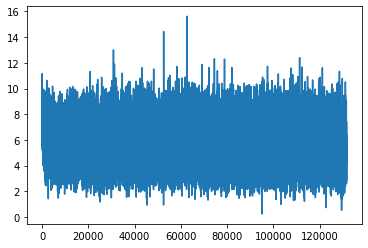

In [ ]:
plt.figure()
plt.plot(range(len(training_losses)), training_losses)
plt.show()

# General Performance

In [ ]:
# create dataloader once
!python data/dataloader_EN_NL_labels.py

In [ ]:
# load test set
with open('./data/Test/dataloader_test_EN.p', 'rb') as f:
    EN_test_set = pkl.load(f)

## Our transfer model

Run on test set, save losses and errors for all test instances

In [ ]:
# Initialize
from dataloader_padded import load_padded_batches_TEST
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_encoder = BertModel.from_pretrained('bert-base-cased').to(device)
BERT_encoder.eval()

# load the EN2NL HEAD
EN2NL_head = torch.load(f"./models/EN2NL_final.pt").to(device)
EN2NL_head.eval()

all_binary_errors = []
all_losses = []

with torch.no_grad():

    # set reduction to none to save losses for every instance
    CE_loss = nn.CrossEntropyLoss(reduction='none')
    
    # iterate over the batches
    for i, (x, y, attn_masks, idx) in enumerate(load_padded_batches_TEST(EN_test_set, batch_size=32)):
        B = x.shape[0]

        x = torch.Tensor(x).to(device).long()
        y = torch.Tensor(y).to(device).long()
        attn_masks = torch.Tensor(attn_masks).to(device).long()

        # get BERT encodings and prediction from our custom head
        encoded_input = BERT_encoder(x, attention_mask=attn_masks)[0]
        relevant_encodings = torch.stack([encoded_input[j, idx[j], :] for j in range(B)])
        predictions = EN2NL_head(relevant_encodings)

        # extract top 5 predictions and save
        top_5 = torch.argsort(predictions, dim=1, descending=True)[:,:5]
        top_5_errors = [1 if y[k] in li else 0 for k, li in enumerate(top_5)]
        all_binary_errors += top_5_errors

        # get loss per training instance
        non_reduced_loss = CE_loss(predictions, y)
    
        # save all individual training losses
        for ind_loss in non_reduced_loss:
            all_losses.append(ind_loss.item())

        # compute the batch loss 
        loss = torch.mean(non_reduced_loss)

        if i % 500 == 0:
            print(f"loss at batch {i}: {loss.item()}")

    with open("./data/metrics/all_losses_EN_test_final.p", "wb") as f:
        pkl.dump(all_losses, f)

    with open("./data/metrics/binary_errors_EN_test_final.p", "wb") as f:
        pkl.dump(all_binary_errors, f)


loss at batch 0: 5.727734565734863
loss at batch 500: 5.952968597412109
loss at batch 1000: 4.878789901733398
loss at batch 1500: 5.869341850280762
loss at batch 2000: 6.19115686416626
loss at batch 2500: 5.702114105224609
loss at batch 3000: 4.968757152557373
loss at batch 3500: 6.705293655395508
loss at batch 4000: 5.674705505371094
loss at batch 4500: 5.338405609130859
loss at batch 5000: 5.181361198425293
loss at batch 5500: 6.495500564575195
loss at batch 6000: 4.248301029205322
loss at batch 6500: 5.975327968597412
loss at batch 7000: 5.468207359313965
loss at batch 7500: 5.435983657836914


In [ ]:
# print evaluation statistics
with open(f"./data/metrics/all_losses_EN_test_final.p", "rb") as f:
    all_losses_final = pkl.load(f)
print(f"Mean loss our model: {np.mean(all_losses_final)}, perplexity: {np.exp(np.mean(all_losses_final))}")

with open(f"./data/metrics/binary_errors_EN_test_final.p", "rb") as f:
    binary_errors_final = pkl.load(f)
print(f"Mean binary errors (accuracy): {np.mean(binary_errors_final)}")


Mean loss our model final: 5.826997689901793, perplexity: 339.33834921230573
Mean binary errors final: 0.37911686586985394


## BERTJE (Native Model)

In [ ]:
# create dataloader
!python data/dataloader.py

In [ ]:
# load in separate cell to reduce running time
with open('./data/Test/NL_test_dataloader.p', 'rb') as f:
    NL_test_set = pkl.load(f)

In [ ]:
# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERTje = BertForMaskedLM.from_pretrained("wietsedv/bert-base-dutch-cased").to(device)
BERTje.eval()

from dataloader_padded import load_padded_batches_TEST

all_binary_errors = []
all_losses = []

with torch.no_grad():

    # keep track of the individual indices for which the correct word is not in the top 5
    CE_loss = nn.CrossEntropyLoss(reduction='none')
    
    for i, (x, y, attn_masks, idx) in enumerate(load_padded_batches_TEST(NL_test_set, batch_size=32)):
        B = x.shape[0]
        
        # set all tensors to device and in correct format
        x = torch.Tensor(x).to(device).long()
        y = torch.Tensor(y).to(device).long()
        attn_masks = torch.Tensor(attn_masks).to(device).long()

        # get predictions and word scores
        predictions = BERTje(x, attention_mask=attn_masks)[0]
        word_scores = torch.stack([predictions[j, idx[j], :] for j in range(B)])

        # extract top 5 predictions and save correct / wrong
        top_5 = torch.argsort(word_scores, dim=1, descending=True)[:,:5]
        top_5_errors = [1 if y[k] in li else 0 for k, li in enumerate(top_5)]
        all_binary_errors += top_5_errors
        
        # get loss per training instance
        non_reduced_loss = CE_loss(word_scores, y) # tensor of size batch size
        
        # save individual training losses
        for ind_loss in non_reduced_loss:
            all_losses.append(ind_loss.item())

        loss = torch.mean(non_reduced_loss)

        if i % 100 == 0:
            print(f"loss at batch {i}: {loss.item()}")

    with open("./data/metrics/all_losses_NL_test.p", "wb") as f:
        pkl.dump(all_losses, f)

    with open("./data/metrics/binary_errors_NL_test.p", "wb") as f:
        pkl.dump(all_binary_errors, f)


In [ ]:
# general performance BERTje
with open(f"./data/metrics/all_losses_NL_test.p", "rb") as f:
        all_losses = pkl.load(f)
print(f"Mean loss native model (BERTje): {np.mean(all_losses)}, perplexity: {np.exp(np.mean(all_losses))}")

with open(f"./data/metrics/binary_errors_NL_test.p", "rb") as f:
        binary_errors = pkl.load(f)
print(f"Accuracy native model (BERTje): {np.mean(binary_errors)}")

Mean loss native model (BERTje): 2.838130047092162, perplexity: 17.083789767519054
Mean loss native model (BERTje): 0.6848066069057105


# Experiment: Sentence Length


The pipeline in this section is as follows:
- We open the dataloader and the losses for all test instances from a saved pickle
- We create a dictionary with all the losses per sentence length
- Then we compute the average loss per sentence length, and exponentiate this loss to obtain the perplexity per length
- A plot is created

In [ ]:
from collections import defaultdict
# set language for analysis: EN is our model, NL is the native BERTje model.
# after running this cell, the following cells will act accordingly
language = "EN"
# language = "NL"

In [ ]:
if language == "EN":
    with open(f'./data/Test/dataloader_test_EN.p', 'rb') as f:
        test_set = pkl.load(f)
elif language == "NL":
    with open('./data/Test/NL_test_dataloader.p', 'rb') as f:
        test_set = pkl.load(f)
else:
    raise ValueError("Incorrect language specified")

In [ ]:
if language == "EN":
    with open(f"./data/metrics/all_losses_EN_test_final.p", "rb") as f:
        all_losses = pkl.load(f)
elif language == "NL":    
    with open(f"./data/metrics/all_losses_NL_test.p", "rb") as f:
        all_losses = pkl.load(f)

In [ ]:
# get a list of all the sentence lengths and corresponding losses
losses_per_length = defaultdict(list)
length_counter = defaultdict(int)
for iter_, ((sent, _, _), loss) in enumerate(zip(test_set, all_losses)):
    length = list(sent.shape)[0]
    length_counter[length] += 1
    losses_per_length[length].append(loss)

print(f"Number of different sentence lengths: {len(list(losses_per_length.keys()))}")

with open(f"./data/metrics/losses_per_length_{language}.p", "wb") as f:
    pkl.dump(losses_per_length, f)


Number of different sentence lengths: 103


In [ ]:
# compute the average loss and perplexity per sentence length
with open(f"./data/metrics/losses_per_length_{language}.p", "rb") as f:
    losses_per_length = pkl.load(f)

perplexity_per_length = dict()
for length, losses in losses_per_length.items():
    mean_loss = np.mean(losses)
    if len(losses) > length:
        perplexity_per_length[length] = np.exp(mean_loss)

with open(f"./data/metrics/perplexity_length_{language}.p", "wb") as f:
    pkl.dump(perplexity_per_length, f)

## Plot perplexities for both models

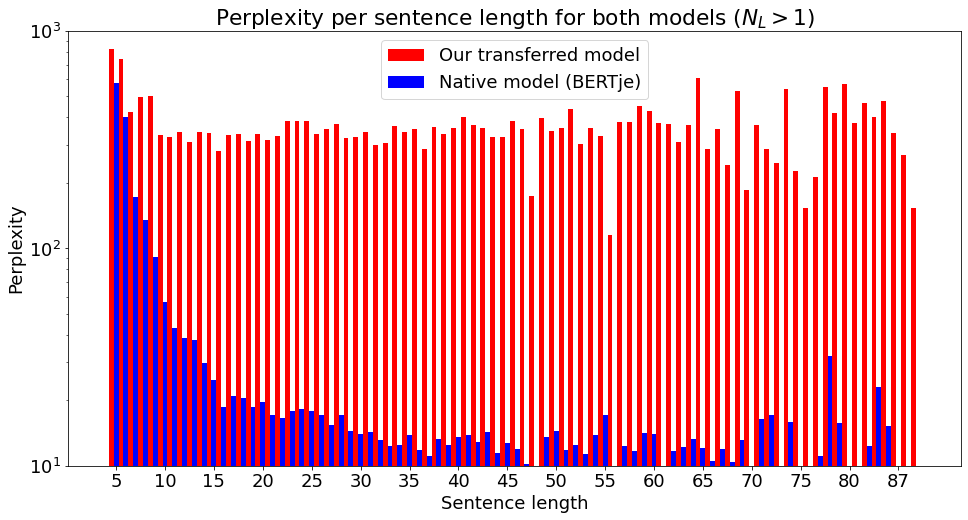

In [ ]:
import matplotlib
# read perplexities
with open(f"./data/metrics/perplexity_length_EN.p", "rb") as f:
    perplexity_per_length_EN = pkl.load(f)
with open(f"./data/metrics/perplexity_length_NL.p", "rb") as f:
    perplexity_per_length_NL = pkl.load(f)


matplotlib.rcParams.update({'font.size': 18})
barWidth = 0.5

# extract lengths and perplexities
lengths_EN = list(perplexity_per_length_EN.keys())
perplexities_EN = list(perplexity_per_length_EN.values())
lengths_NL = list(perplexity_per_length_NL.keys())
perplexities_NL = list(perplexity_per_length_NL.values())

# sort perplexities based on length
lengths_EN, perplexities_EN = zip(*sorted(zip(lengths_EN, perplexities_EN)))
lengths_NL, perplexities_NL = zip(*sorted(zip(lengths_NL, perplexities_NL)))

x = np.arange(len(lengths_EN))

# plot bar chart
plt.figure(figsize=(16,8))
plt.bar(x, perplexities_EN,color='r', label="Our transferred model", width=barWidth)
plt.bar([i+barWidth for i in x], perplexities_NL,color='b', label="Native model (BERTje)", width=barWidth)
plt.xticks([r+barWidth for r in range(0, len(lengths_EN), 5)], lengths_EN[::5])
plt.yscale('log')
plt.ylim(10**1, 10**3)
plt.title("Perplexity per sentence length for both models ($N_L > 1$)")
plt.ylabel("Perplexity")
plt.xlabel("Sentence length")
plt.legend()
plt.show()

# Experiment: POS-tag analysis

In [ ]:
# create dataset once
!pip install -U spacy
!python -m spacy download nl_core_news_sm
!python data/dataloader_pos.py

In [ ]:
with open('./data/Test/dataloader_pos_tagged.p', 'rb') as f:
    test_set_pos_tagged = pkl.load(f)
with open(f'./data/metrics/binary_errors_EN_test_final.p', 'rb') as f:
    all_top5_errors_EN = pkl.load(f)
with open(f'./data/metrics/binary_errors_NL_test.p', 'rb') as f:
    all_top5_errors_NL = pkl.load(f)

In [ ]:
# errors are indicated by 0, correct by 1
def get_error_tags(test_set_pos_tagged, all_top_5_errors):
    pos_tags = [tags[i] for (_, _, tags, i) in test_set_pos_tagged]
    error_tags = Counter()
    all_tags = Counter()
    for i, tag in enumerate(pos_tags[:-10]):
        if all_top_5_errors[i] == 0:
            error_tags[tag] += 1
        all_tags[tag] += 1

    return all_tags, error_tags

_, error_tags_EN = get_error_tags(test_set_pos_tagged, all_top5_errors_EN)
all_tags, error_tags_NL = get_error_tags(test_set_pos_tagged, all_top5_errors_NL)

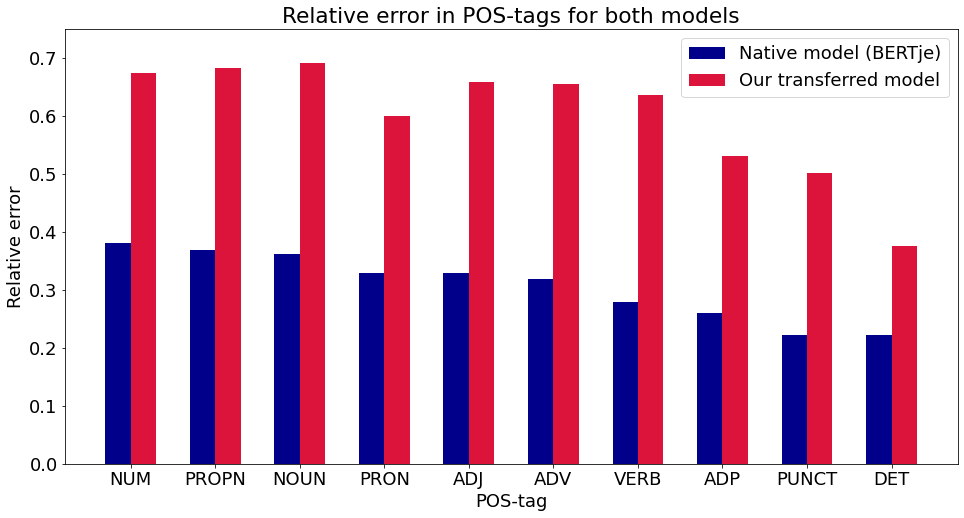

In [ ]:
# plot the results
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

# get 10 most frequent NL keys
keys_NL = [i for i in error_tags_NL.most_common(10)]
values_NL = [v/all_tags[k] for k, v in keys_NL]

# sort both lists on the values
values_NL, keys_NL = zip(*sorted(zip(values_NL, keys_NL))[::-1])
values_EN = [error_tags_EN[k]/all_tags[k] for k, _ in keys_NL]

labels = [i[0] for i in keys_NL]
barwidth = 0.3

plt.figure(figsize=(16, 8))
x = np.arange(len(keys_NL))
plt.bar(x, values_NL, color='darkblue', label="Native model (BERTje)", width=barwidth)
plt.bar([i+barwidth for i in x], values_EN, color= 'crimson', label="Our transferred model", width=barwidth)
plt.xticks([r+1/2*barwidth for r in range(len(labels))], labels)
plt.ylim(0, 0.75)
plt.ylabel('Relative error')
plt.xlabel("POS-tag")
plt.title(f"Relative error in POS-tags for both models")
plt.legend()
plt.show()

# Comparison MLP and manual Translation

In [ ]:
# In this cell an example sentence is translated using our learned transformation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_en_embeddings = bert_embeds(torch.Tensor(list(range(bert_tokenizer.vocab_size))).to(device).long())
all_nl_embeddings = bertje_embeds(torch.Tensor(list(range(bertje_tokenizer.vocab_size))).to(device).long())
cossim = nn.CosineSimilarity(dim=-1)
net = torch.load("./models/MLP_final.pt", map_location=device)

with torch.no_grad():
    dutch_text = 'Bert is de langste van de twee; hij heeft een lang geel hoofd met een oranje neus, een verticaal gestreepte trui en is duidelijk herkenbaar aan zijn ene doorlopende wenkbrauw.'
    tokenized_sentence = bertje_tokenizer.tokenize(dutch_text)
    print(f"Dutch text: {dutch_text}")
    print(f"Tokenized text: {tokenized_sentence}")

    # convert sentence to embeddings
    dutch_embedding = bertje_embeds(torch.Tensor(
        bertje_tokenizer.convert_tokens_to_ids(tokenized_sentence)).long().to(device))
    
    # feed the batch with all embeddings for the words in the sentence to MLP
    en_embeddings = net(dutch_embedding)

    print(f"Translation: ", end=" "))
    # for every word find the closest embedding
    for word_embed in en_embeddings:
        cosine = cossim(all_en_embeddings, word_embed)
        best_token = torch.argmax(cosine)
        best_match = bert_tokenizer.convert_ids_to_tokens([best_token])
        print(best_match[0], end=" ")
    print("\n")

Bert is de langste van de twee; hij heeft een lang geel hoofd met een oranje neus, een verticaal gestreepte trui en is duidelijk herkenbaar aan zijn ene doorlopende wenkbrauw.
['Bert', 'is', 'de', 'langste', 'van', 'de', 'twee', ';', 'hij', 'heeft', 'een', 'lang', 'geel', 'hoofd', 'met', 'een', 'oranje', 'neus', ',', 'een', 'verticaal', 'gestreept', '##e', 'trui', 'en', 'is', 'duidelijk', 'herkenbaar', 'aan', 'zijn', 'en', '##e', 'doorlopen', '##de', 'wenkbrauw', '.']
570 is the longest from the three but he has a long yellow head with a yellow nose and a horizontal striped , sweater and is clearly recognizable on his and , enter with eyebrow with 



# Comparison with Google Translate data


In [ ]:
# create dataloaders once
!python data/dataloader_gt_EN_labels.py
!python data/dataloader_EN_labels.py

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set experiment type, see descriptions in if statement below
experiment = 1 # can be 1, 2, 3

if experiment == 1:
    # Google translated dataset with english labels (BERT only)
    with open('./data/GT/google_translate_dataloader_en_labels.p', "rb") as f:
        dataset = pkl.load(f)
    BERT = BertForMaskedLM.from_pretrained('bert-base-cased').to(device)
    BERT.eval()  
    print("Running Google translated dataset with English labels, using full BERT architecture")

elif experiment == 2:
    # MLP translated dataset with english labels (BERT only)
    with open('./data/Test/EN_test_EN_labels.p', "rb") as f:
        dataset = pkl.load(f)
    BERT = BertForMaskedLM.from_pretrained('bert-base-cased').to(device)
    BERT.eval()
    print("Running MLP translated dataset with English labels, using full BERT architecture")

elif experiment == 3:
    # MLP translated dataset with Dutch labels (default pipeline) (BERT encoder + custom head)
    with open('./data/Test/dataloader_test_EN.p', "rb") as f:
        dataset = pkl.load(f)
    BERT_encoder = BertModel.from_pretrained('bert-base-cased').to(device)
    BERT_encoder.eval()
    EN2NL_head = torch.load("./models/EN2NL_final.pt").to(device)
    EN2NL_head.eval()
    print("Running MLP translated dataset with Dutch labels, using BERT encoder and our custom prediction head")
 
else:
    raise ValueError("Incorrect experiment number")

from dataloader_padded import load_padded_batches_TEST
loss_fn = nn.CrossEntropyLoss(reduction='none')
training_losses = []

# run the experiment on the correct test set
with torch.no_grad():
    for i, (x, y, attn_masks, idx) in enumerate(load_padded_batches_TEST(dataset, batch_size=32)):
        B = x.shape[0]
        if i % 500 == 0:
            print(f"iter: {i}")
        
        x = torch.Tensor(x).to(device).long()
        y = torch.Tensor(y).to(device).long()
        attn_masks = torch.Tensor(attn_masks).to(device).long()
        
        # get predictions from correct models
        if experiment in [1, 2]:
            predictions = BERT(x, attention_mask=attn_masks)[0]
            predictions = torch.stack([predictions[j, idx[j], :] for j in range(B)])
        elif experiment == 3:
            encoded_input = BERT_encoder(x, attention_mask=attn_masks)[0]
            relevant_encodings = torch.stack([encoded_input[j, idx[j], :] for j in range(B)])
            predictions = EN2NL_head(relevant_encodings)

        non_reduced_loss = loss_fn(predictions, y)
    
        for ind_loss in non_reduced_loss:
            training_losses.append(ind_loss.item())

    # save the losses
    if experiment == 1:
        with open("./data/metrics/training_losses_Google_EN_labels.pt", "wb") as f:
            pkl.dump(training_losses, f)
    elif experiment == 2:
        with open("./data/metrics/training_losses_MLP_EN_labels.pt", "wb") as f:
            pkl.dump(training_losses, f)
    elif experiment == 3:
        with open("./data/metrics/training_losses_MLP_NL_labels.pt", "wb") as f:
            pkl.dump(training_losses, f)


Running Google translated dataset with English labels, using full BERT architecture
iter: 0
iter: 500
iter: 1000
iter: 1500
iter: 2000
iter: 2500
iter: 3000
iter: 3500
iter: 4000
iter: 4500
iter: 5000
iter: 5500
iter: 6000
iter: 6500
iter: 7000


### Experiment 1

In [ ]:
# google translation with full BERT architecture (baseline, no own models)
with open("./data/metrics/training_losses_Google_EN_labels.pt", "rb") as f:
    training_losses = pkl.load(f)

print(f"Results for {len(training_losses)} instances")

mean_CE_loss = np.mean(training_losses)
perplexity = np.exp(mean_CE_loss)
print(f"Mean CE loss: {mean_CE_loss}, perplexity: {perplexity}")

Results for 234464 instances
Mean CE loss: 3.172593301315416, perplexity: 23.869304461360564


### Experiment 2

In [ ]:
# Own MLP translation + full BERT architecture (EN labels)
with open("./data/metrics/training_losses_MLP_EN_labels.pt", "rb") as f:
    training_losses = pkl.load(f)

print(f"Results for {len(training_losses)} instances")
mean_CE_loss = np.mean(training_losses)
perplexity = np.exp(mean_CE_loss)
print(f"Mean CE loss: {mean_CE_loss}, perplexity: {perplexity}")

Results for 240960 instances
Mean CE loss: 7.001859089878609, perplexity: 1098.673794308856


### Experiment 3

In [ ]:
# MLP translation + BERT encoder + own prediction head (NL labels) --> default pipeline
with open("./data/metrics/training_losses_MLP_NL_labels.pt", "rb") as f:
    training_losses = pkl.load(f)

print(f"Results for {len(training_losses)} instances")
mean_CE_loss = np.mean(training_losses)
perplexity = np.exp(mean_CE_loss)
print(f"Mean CE loss: {mean_CE_loss}, perplexity: {perplexity}")

Ran 240960 batches
Mean CE loss: 5.943471048905911, perplexity: 381.2559936723735
